# **Homework 3: Semantic Role Labeling**
## CS4740/5740 Fall 2022 

## Grouping deadline: Oct. 30th 11:59pm on CMS (site will open soon)

## Milestone 1 Due: Nov. 4th, 11:59pm  on CMS (submit your first model test set result on Kaggle)
## Project Submission Due: Thursday Nov 15th, 11:59pm 


**Names:** Jiaqi Liang, Fengyue(Lisa) Zhao

**Netids:** jl4274, fz227

**Editing your version of this notebook:** One partner should make a copy of this notebook and share it with your partner.  **However**, because of synchronization issues (even though Colab works with Google Drive), changes made in this notebook at the same time from different computers/browser windows may not save. We will go so far as to recommend that you close the tab with this notebook when you are not working on it so your partner doesn't face sync issues.

**Collaboration policy:** Please be sure to check the collaboration policy on the [course website](https://courses.cs.cornell.edu/cs4740/2022fa/)!

**Coding cells:** Any cells that require you to code will have the `### TODO : [description] ###` comment, where the `[description]` varies per cell.

**Cell Outputs:** For grading (aka to help us give you partial credit), please ensure the final cell outputs are present for all cells in the notebook you submit.

**Teams/groups:** Everyone resets to a "singleton" when each new assignment is released.  If you want to have a partner for HW3, regardless of whether it's a previous homework partner or a new one, you must do the CMS invite/accept process anew.

Code of Academic Integrity:  **Do not copy code from online or share code with students other than your designated partner**. We will be running programs to detect plagiarism.

Kaggle for HW3: https://www.kaggle.com/t/fa506c5c444f43469a693f8366bd23a2

**What to submit**:
upload your two models and jupyter notebook to **CMS** and pdf to Gradescope

# **Introduction** 
---

Semantic Role Labeling (SRL) is the task of automatically labelling the semantic roles of each argument according to each predicate in a passage. **Predicates** (e.g., bought, sell, purchasing) represent events, and each sentence can have more than one predicate. **Semantic roles** express the abstract roles that predicate arguments can take in the event. Typical semantic arguments include Agent, Patient, and Instrument, and also adjunctive arguments indicating Locative, Temporal, Manner, Cause, and other aspects. Recognizing and labeling semantic arguments is a key task for answering "Who", "When", "What", "Where", and "Why" questions in Information Extraction, Question Answering, Summarization, and, in general, in all NLP tasks in which some kind of semantic interpretation is needed.

The following sentence, exemplifies the annotation of semantic roles:

[Arg0 He ] would n't accept [Arg1 anything of value ] from [Arg2 those he was writing about ] .

Here, the roles for the **predicate 'accept'** (that is, the roleset of the predicate) are defined in the PropBank Frames scheme as: \\

> **Arg0**: Agent \\
**Arg1**: Patient \\
**Arg2**: Instrument, benefactive, attribute \\
**ArgM-LOC**: Locative modifiers indicate where some action takes place. The notion of a locative is not
restricted to physical locations, but abstract locations are being marked as LOC as well, as "[in his speech]-LOC he was talking about …".  \\
**ArgM-TMP**: Temporal ArgMs show when an action took place, such as "in 1987", "last Wednesday","soon" or "immediately". Also included in this category are adverbs of frequency (eg. often
always, sometimes), adverbs of duration
(for a year/in an year), order (eg. first), and repetition (eg. again)..  

For this homework, the predicate is given for every sentence. Your task is to implement 2 models to predict A0/A1/A2/ArgM-LOC/ArgM-TMP.




## **Advice**

---
1. We strongly encourage you to enable GPU support (Google Colab provides GPUs if you don't have them locally). To do so, go to `Runtime` --> `Change Runtime Type` --> Dropdown box below `Hardware Accelerator` --> `GPU`. This will help your models train *much* faster!
2. Please read through the entire notebook before you start coding. That might inform your code structure.
3. An assignment outline and grading breakdown (subject to minor adjustments) is found below; please consult it.

<a name="outline"></a>
## **Assignment outline and grading breakdown**
- [Part 1](#part1) Preparing Data
- [Part 2](#part2) LSTM Encoder implementation
  - [Implement LSTM Encoder Model](#l2)
      - Initialization [4 pts]
      - Forward [10 pts]    
  - [Submission to Kaggle](#l3) [5 pts]
  - [Q2.1](#Q2.1) [3 pts]    
  - [Q2.2](#Q2.2) [3 pts]       
- [Part 3](#part3) SRL Model Implementation
  - [Implement Encoder-Decoder Model](#l4) 
    - Encoder
      - Initialization [3 pts]
      - Forward [10 pts]
    - Decoder 
      - Initialization [4 pts]
      - Forward [10 pts]
      - Step [10 pts]
  - [Submission to Kaggle](#l5) [5 pts]
  - [Q3.1](#Q3.1) [3 pts]
- [Part 4](#part4) [10 pts]
- [Part 5](#part5)
  - Outperforming our LSTM baseline on Kaggle [5 pts]
  - Outperforming our Encoder-Decoder baseline on Kaggle [10 pts]
- **Milestone 1 submission** [5 pts]

**A brief note on the Kaggle baselines:** To give you some breathing room for your implementation, our baselines are *not* perfect implementations. Correct implementations should therefore outperform our baselines.

<a name="part1"></a>
[[^^^]](#outline) 
# **Part 1: Preparing Data**

In this part, data will be converted into a format that can be passed through both of our models.


In [ ]:
# Installing gensim (if needed)
!pip install -U gensim
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from collections import Counter, namedtuple
from itertools import chain
import json
import math
import os
from pathlib import Path
import random
import time
from tqdm.notebook import tqdm, trange
from typing import List, Tuple, Dict, Set, Union
import sys

import gensim
import nltk
import matplotlib.pyplot as plt 
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
import numpy as np
import sentencepiece as spm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.utils
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence


from tqdm.notebook import tqdm, trange

##1.1: Data Loading
First, we need to load in the data from our Google Drive. Please adjust the following code to fit your drive's organization.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### TODO : please modify the line below with your drive organization ###
#path = os.path.join(os.getcwd(), "drive", "My Drive", "homework3", "hw3_data")
path = os.path.join(os.getcwd(), "drive", "My Drive", "CS 5740", "HW3_DATA")
with open(os.path.join(path,'train.json'), 'r') as f:
     train = json.loads(f.read())

with open(os.path.join(path,'valid.json'), 'r') as f:
     val = json.loads(f.read())

with open(os.path.join(path,'test.json'), 'r') as f:
     test = json.loads(f.read())
     

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.2: Preprocess Data
Currently, the dataset has four fields: 
1. 'text' is a list of a list of tokens(string)
2. 'verb_index' represents the **relative position** of the **predicate verb** in the sentence. (Type: a list of a list of integers)
 
> Example: He would n't accept anything of value from those he was writing about.

> Verb index: 3, because accept is the fourth word of the sentence (indexing starts from zero).


3. 'srl_label' is the semantic role label of every token. (Type: a list of a list of strings) \\

4. 'word_indices' is the index of every word token (same as howework 1&2, Type: a list of a list of integers)

We could try printing out the second training sentence as an example of the dataset. \\
The verb_index here is 4, which means the fifth word of the sentence ("coordinated") is the **predicate**.

In [ ]:
print(train['verb_index'][1])
print(train['text'][1])
print(train['words_indices'][1])
print(train['srl_frames'][1])

4
['The', 'progress', 'of', 'this', 'coordinated', 'offensive', 'was', 'already', 'very', 'entrenched', 'by', 'then', '.']
[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
['O', 'O', 'O', 'O', 'O', 'B-ARG1', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


### **Converting Labels to Numerical Values**
In addition to converting our tokens to vector representations, we need to convert our labels to numerical representations. For example, say we have two labels: "O", "B-ARG0". We could numerically represent these labels in a dictionary as Label 0 and Label 1: `{"O":0, "B-ARG":1}`. The following function is implemented for you, and it encodes the labels present in the dataset. No modifications are necessary.


In [ ]:
srl_map = {'O': 0,
           'B-ARG0': 1,
           'I-ARG0': 2,
           'B-ARG1': 3,
           'I-ARG1': 4,
           'B-ARG2': 5,
           'I-ARG2': 6,
           'B-ARGM-LOC': 7,
           'I-ARGM-LOC': 8,
           'B-ARGM-TMP': 9,
           'I-ARGM-TMP': 10}

def encode_srl_category(category_data: List[List[str]])->List[List[int]]:
  """ Encoding SRL category from a list of strings to a list of integers

  Arguments: 
    category_data (list(list(str))): SRL categories

  Returns:
    encoded category (list(list(int))): Numerical conversions of SRL categories
  """
  encoded_category = []
  for srl_list in category_data:
    encoded_srl_list = []
    for srl in srl_list:
      try:
        encoded_srl_list.append(srl_map[srl])
      except:
        encoded_srl_list.append(0)
    encoded_category.append(encoded_srl_list)
  return encoded_category

In [ ]:
################################################################################
#########################             ADDED             ########################
################################################################################
def get_masks(sents_padded, pad_token):
    """ Create masks for a list of sentences according to the longest sentence 
        in the training data.
        The mask should be a binary array.
    
    Arguments:
      sents_padded(list[list[str]]): list of sentences where sentences shorter
        than the max length sentence are padded out with the pad_token, such that
        each sentence in the batch now has equal length.

      pad_token(str): padding token

    Returns:
      sents_masks(list[list[Int]]): list of 0/1 where words shorter
        than the max length in the sentence are denoted as 1 and 0 otherwise.
    """
    all_masks = []
    for sent in sents_padded:
      all_masks.append([0 if w == pad_token else 1 for w in sent])
    return all_masks

We have also provided the `pad_sents` function, which pads all sentences to be the same length, specifically the length of the longest input sentence, using the provided `pad_token`. Finally, we have provided the `Vocab` class that represents the corpus as a `Vocab` object with several helper functions. These are used to preprocess the training set for you.

In [ ]:
def pad_sents(sents, pad_token):
    sents_padded = []

    max_len = max([len(sent) for sent in sents])
    sents_padded = [(sent + ([pad_token] * (max_len - len(sent)))) for sent in sents]

    return sents_padded

class Vocab(object):
    """ Vocabulary, i.e. structure containing either
    src or tgt language terms.
    """
    def __init__(self, word2id=None):
        """ Init Vocab Instance.
        
        :param word2id: dictionary mapping words 2 indices
        :type word2id: dict[str, int]
        """
        if word2id:
            self.word2id = word2id
        else:
            self.word2id = dict()
            self.word2id['<pad>'] = 0   # Pad Token
            self.word2id['<s>'] = 1 # Start Token
            self.word2id['</s>'] = 2    # End Token
            self.word2id['<unk>'] = 3   # Unknown Token
        self.unk_id = self.word2id['<unk>']
        self.id2word = {v: k for k, v in self.word2id.items()}

    def __getitem__(self, word):
        """ Retrieve word's index. Return the index for the unk
        token if the word is out of vocabulary.
        
        :param word: word to look up
        :type word: str
        :returns: index of word
        :rtype: int
        """
        return self.word2id.get(word, self.unk_id)

    def __contains__(self, word):
        """ Check if word is captured by Vocab.
        
        :param word: word to look up
        :type word: str
        :returns: whether word is in vocab
        :rtype: bool
        """
        return word in self.word2id

    def __setitem__(self, key, value):
        """ Raise error, if one tries to edit the Vocab directly.
        """
        raise ValueError('vocabulary is readonly')

    def __len__(self):
        """ Compute number of words in Voca.
        
        :returns: number of words in Vocab
        :rtype: int
        """
        return len(self.word2id)

    def __repr__(self):
        """ Representation of Vocab to be used
        when printing the object.
        """
        return 'Vocabulary[size=%d]' % len(self)

    def add(self, word):
        """ Add word to Vocab, if it is previously unseen.
        
        :param word: to add to Vocab
        :type word: str
        :returns: index that the word has been assigned
        :rtype: int
        """
        if word not in self:
            wid = self.word2id[word] = len(self)
            self.id2word[wid] = word
            return wid
        else:
            return self[word]

    def words2indices(self, sents):
        """ Convert list of words or list of sentences of words
        into list or list of list of indices.
        
        :param sents: sentence(s) in words
        :type sents: Union[List[str], List[List[str]]]
        :returns: sentence(s) in indices
        :rtype: Union[List[int], List[List[int]]]
        """
        if type(sents[0]) == list:
            return [[self[w] for w in s] for s in sents]
        else:
            return [self[w] for w in sents]

    def indices2words(self, word_ids):
        """ Convert list of indices into words.
        
        :param word_ids: list of word ids
        :type word_ids: List[int]
        :returns: list of words
        :rtype: List[Str]
        """
        return [self.id2word[w_id] for w_id in word_ids]

    def to_input_tensor(self, sents: List[List[str]], device: torch.device) -> torch.Tensor:
        """ Convert list of sentences (words) into tensor with necessary padding for 
        shorter sentences.
        
        :param sents: list of sentences (words)
        :type sents: List[List[str]]
        :param device: Device on which to load the tensor, ie. CPU or GPU
        :type device: torch.device
        :returns: Sentence tensor of (max_sentence_length, batch_size)
        :rtype: torch.Tensor
        """
        word_ids = self.words2indices(sents)
        sents_t = pad_sents(word_ids, self['<pad>'])
        sents_var = torch.tensor(sents_t, dtype=torch.long, device=device)
        return sents_var

    @staticmethod
    def from_corpus(corpus, size, remove_frac=None, freq_cutoff=None): 
        """ Given a corpus construct a Vocab.
        
        :param corpus: corpus of text produced by read_corpus function
        :type corpus: List[str]
        :param freq_cutoff: if word occurs n < freq_cutoff times, drop the word
        :type freq_cutoff: int
        :returns: Vocab instance produced from provided corpus
        :rtype: Vocab
        """
        vocab_entry = Vocab()
        word_freq = Counter(chain(*corpus))
        if freq_cutoff is None:
            freq_cutoff = 1
        valid_words = [w for w, v in word_freq.items() if v >= freq_cutoff]
        print('number of word types: {}, number of word types w/ frequency >= {}: {}'
              .format(len(word_freq), freq_cutoff, len(valid_words)))
        top_words = sorted(valid_words, key=lambda word: word_freq[word], reverse=True)
        if remove_frac is not None:
            size = len(top_words) - int(remove_frac * len(top_words))
            top_words = top_words[:size]
            print(f'number of unique words retained with remove_frac={remove_frac}: {len(top_words)}')
        for word in top_words:
            vocab_entry.add(word)
        return vocab_entry
    
    @staticmethod
    def from_subword_list(subword_list):
        """Given a list of subwords, construct the Vocab.
        
        :param subword_list: list of subwords in corpus
        :type subword_list: List[str]
        :returns: Vocab instance produced from provided list
        :rtype: Vocab
        """
        vocab_entry = Vocab()
        for subword in subword_list:
            vocab_entry.add(subword)
        return vocab_entry


In [ ]:
# sents_padded = [['a', 'b', '<pad>']]
# pad_token = '<pad>'
# get_masks(sents_padded, pad_token)


# **Part 2: LSTM Encoder Model**

<a name="part2"></a>

We are using a single layer LSTM to predict Semantic Role Labels in our first model.

Input: word tokens $\vec{x}_1,\vec{x}_2, \dots, \vec{x}_k$ and index $i$ of the verb ($\vec{x}_i$) in the sentence \

In the neural network:
1.   Pass each word embedding to the LSTM and get the corresponding LSTM hidden layer.
2.   Get hidden state of the predicate in the sentence
2.   Concatenate the hidden states with the predicate hidden state.
3.   Pass the concatenated embedding through a linear layer to generate output





In this part, you need to implement an LSTM Encoder in PyTorch. Since you already understand how to implement RNNs from HW2, you are now allowed, **and encouraged** to use the torch.nn.LSTM function. https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
(tip: read the documention and understand the parameter: "batch_first")

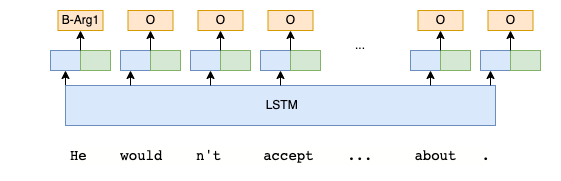

In [ ]:
# Setting seed ***DO NOT MODIFY***
torch.manual_seed(123)

print('initialize train vocabulary ..')
src_vocab = Vocab.from_corpus(train['text'], 20000, remove_frac=0.3) 

initialize train vocabulary ..
number of word types: 19082, number of word types w/ frequency >= 1: 19082
number of unique words retained with remove_frac=0.3: 13358


In [ ]:
train_data = list(zip(train['text'],train['verb_index'],encode_srl_category(train['srl_frames'])))
val_data = list(zip(val['text'], val['verb_index'], encode_srl_category(val['srl_frames'])))


In [ ]:
print(train_data[0])

(['A', 'primary', 'stele', ',', 'three', 'secondary', 'steles', ',', 'and', 'two', 'inscribed', 'steles', '.'], 10, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0])


In [ ]:
# Lambda to switch to GPU if available
get_device = lambda : "cuda:0" if torch.cuda.is_available() else "cpu"


## 2.1 Implementation

Your first task is to **implement the model below by finishing the #TODOs**.


<a name="l2"></a>

In [ ]:
from torch import lstm
class LSTMTagger(nn.Module):
    def __init__(self, src_vocab, embed_dim,
    hidden_dim, output_dim, vocab_size, num_layers=1):
        '''
        src_vocab: vocabulary of inputs (Class Vocab)
        embed_dim: dimension of word embedding
        hidden_dim: dimension of hidden layer
        output_dim: dimension of tagset_size
        vocab_size: vocabulary size
        num_layers: number of LSTM layers 
        '''
        super(LSTMTagger, self).__init__()
        self.src_vocab = src_vocab
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.embed_dim = embed_dim

        ### TODO : Initialize three linear layers:
        # 1. A word embedding layer
        self.embedding = nn.Embedding(vocab_size, self.embed_dim).to(get_device())
        # 2. A LSTM layer
        self.lstm = nn.LSTM(self.embed_dim, self.hidden_dim, num_layers, batch_first=True).to(get_device())
        # 3. An output linear layer
        self.output = nn.Linear(2*self.hidden_dim, self.output_dim).to(get_device())

        ### TODO : Initialize logsoftmax
        self.softmax = nn.LogSoftmax(dim=-1)

    def compute_Loss(self, criterion, predicted_vector, gold_label):
        loss = 0
        for n in range(len(predicted_vector)): # batch size
            loss += criterion(predicted_vector[n], gold_label[n])	
        return loss

    def forward(self, source: List[List[str]], verb_indices:List[int]):
        ### GOALS : Write the forward function such that it processes sentences. 
        ### GOALS : Return output of the logsoftmax across all time steps
       
        #pad input sentences and convert to word index 
        source_padded = self.src_vocab.to_input_tensor(source, device=get_device())
        batch_size = source_padded.shape[0] 
        time_steps = source_padded.shape[1]

        #set up outputs dimension
        output = torch.zeros(batch_size, time_steps, self.output_dim).to(get_device())

        #TODO1: Convert word index to embedding
        embeddings = self.embedding(source_padded).to(get_device())
        # print("embeddings:", embeddings.shape)

        #TODO2: Pass inputs to the lstm layer
        lstm = self.lstm(embeddings)[0]
        # print("lstm:", lstm.shape)

        #TODO3: Get hidden state of verb in the sentence
        verb_hiddens = torch.zeros(batch_size, self.hidden_dim).to(get_device())

        for i in range(batch_size):
          verb_indice = verb_indices[i]
          # print('verb_indice', verb_indice)
          verb_hidden = lstm[i][verb_indice]
          # print("verb_hidden:",verb_hidden.shape)
          # print("verb_hiddens",verb_hiddens.shape)

          verb_hiddens[i,:] = verb_hidden
          # print("verb_hiddens[i,:]",verb_hiddens[i,:].shape)

        #TODO4: Iterate over the time dimension: 
        #       - Concatenate verb hidden state to the hidden layer output of every token
        #       - Predict SRL tag distribution with output layer and logsoftmax
        for k in range(time_steps):
          mid = torch.cat((lstm[:,k,:], verb_hiddens),dim=-1)
          # print("mid shape:", mid.shape)
          out = self.output(mid)
          # print("out shape:", out.shape)
          out2 = self.softmax(out)
          # print("out2 shape:", out2.shape)
          output[:,k,:] = out2

        return output


    def load_model(self, save_path):
        saved_model = torch.load(save_path)
        self.load_state_dict(saved_model.state_dict())

    def save_model(self, save_path):
        torch.save(self, save_path)


In [ ]:
def batch_iter(data, batch_size, shuffle=False):
    """ Yield batches of input sentence, verb indices, target output labels 
    :param data: list of tuples containing source and target sentence. ie.
        (list of (src_sent, tgt_sent))
    :type data: List[Tuple[List[str], List[str], List[str]]]
    :param batch_size: batch size
    :type batch_size: int
    :param shuffle: whether to randomly shuffle the dataset
    :type shuffle: boolean
    """
    batch_num = math.ceil(len(data) / batch_size)
    index_array = list(range(len(data)))

    if shuffle:
        np.random.shuffle(index_array)

    for i in range(batch_num):
        indices = index_array[i * batch_size: (i + 1) * batch_size]
        examples = [data[idx] for idx in indices]

        examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)
        srl = [e[0] for e in examples]
        verb_index = [e[1] for e in examples]
        target = [e[2] for e in examples]

        yield srl, verb_index, target

In [ ]:
# Setting seed ***DO NOT MODIFY***
torch.manual_seed(123)

def evaluation(model, val_data, optimizer, criterion, batch_size=64):
  model.eval()
  loss = 0
  correct = 0
  total = 0
  batch = 0
  for (input_batch, verb_indices, expected_out) in tqdm(batch_iter(val_data, batch_size=batch_size, shuffle=True)):
    output = model.forward(input_batch, torch.tensor(verb_indices).to(get_device()))
    total += output.size()[0] * output.size()[1]
    _, predicted = torch.max(output, 2)
    expected_out = torch.tensor(pad_sents(expected_out,0))
    correct += (expected_out.to("cpu") == predicted.to("cpu")).cpu().numpy().sum()

    loss += model.compute_Loss(criterion, output.to("cpu"), expected_out.to("cpu"))
    batch += 1
  loss /= batch
  print("Validation Loss: " + str(loss.item()))
  print("Validation Accuracy: " + str(correct/total))
  print()
  return loss.item()

In [ ]:
# Setting seed ***DO NOT MODIFY***
torch.manual_seed(123)

def train_epoch(model, train_data, optimizer, criterion,batch_size=64):
  model.train()
  total = 0
  batch = 0
  total_loss = 0
  correct = 0
  for (input_batch, verb_indices, expected_out) in tqdm(batch_iter(train_data, batch_size=batch_size, shuffle=True)):
    optimizer.zero_grad()
    batch += 1
    output = model.forward(input_batch, torch.tensor(verb_indices).to(get_device()))
    total += output.size()[0] * output.size()[1]
    _, predicted = torch.max(output, 2)

    expected_out = torch.tensor(pad_sents(expected_out,0))
    correct += (expected_out.to("cpu") == predicted.to("cpu")).cpu().numpy().sum()
    
    loss = model.compute_Loss(criterion, output.to("cpu"), expected_out.to("cpu")) 
    total_loss += loss.item()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step() 
  print("Loss: " + str(total_loss/batch))
  print("Training Accuracy: " + str(correct/total))
  return total_loss/batch

In [ ]:
# Setting seed ***DO NOT MODIFY***
torch.manual_seed(123)

def train_and_evaluate(number_of_epochs, model, train_data, val_data, criterion, min_loss=0, lr=.01):
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=.9)
  loss_values = [[],[]]
  for epoch in trange(number_of_epochs, desc="Epochs"):
    cur_loss = train_epoch(model, train_data, optimizer, criterion)
    loss_values[0].append(cur_loss)
    cur_loss_val = evaluation(model, val_data, optimizer, criterion)
    loss_values[1].append(cur_loss_val)
    if cur_loss <= min_loss: return loss_values
  return loss_values
  

**Train your LSTM Encoder Model** with the following cell:

In [ ]:
embed_dim = 64
hidden_dim = 128
weight = torch.ones(len(srl_map))

weight[0] = 0.25
weight[7] = 1.5
weight[8] = 1.5
print(weight)
criterion = nn.NLLLoss(weight=weight)
lstm = LSTMTagger(src_vocab, embed_dim, hidden_dim=hidden_dim, output_dim=len(srl_map), vocab_size=len(src_vocab)).to(get_device())
loss = train_and_evaluate(10, lstm, train_data, val_data, criterion, min_loss=0.01, lr= .05)


tensor([0.2500, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.5000, 1.5000,
        1.0000, 1.0000])


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Loss: 45.76757489717924
Training Accuracy: 0.9026808818306358


0it [00:00, ?it/s]

Validation Loss: 41.240047454833984
Validation Accuracy: 0.8847947761194029



0it [00:00, ?it/s]

Loss: 34.759326476317185
Training Accuracy: 0.9037153016347453


0it [00:00, ?it/s]

Validation Loss: 38.08209991455078
Validation Accuracy: 0.8799927566225165



0it [00:00, ?it/s]

Loss: 31.109892615905174
Training Accuracy: 0.9076201188228308


0it [00:00, ?it/s]

Validation Loss: 37.272438049316406
Validation Accuracy: 0.8922449832775919



0it [00:00, ?it/s]

Loss: 29.061289264605595
Training Accuracy: 0.9095308903445084


0it [00:00, ?it/s]

Validation Loss: 35.92726516723633
Validation Accuracy: 0.890690486169321



0it [00:00, ?it/s]

Loss: 27.107388129601112
Training Accuracy: 0.9132441922686011


0it [00:00, ?it/s]

Validation Loss: 35.850135803222656
Validation Accuracy: 0.888581223628692



0it [00:00, ?it/s]

Loss: 25.519182700377243
Training Accuracy: 0.9163761305643979


0it [00:00, ?it/s]

Validation Loss: 35.1263427734375
Validation Accuracy: 0.8753399581589958



0it [00:00, ?it/s]

Loss: 24.097822656998268
Training Accuracy: 0.9194984329980286


0it [00:00, ?it/s]

Validation Loss: 35.737953186035156
Validation Accuracy: 0.8753385416666667



0it [00:00, ?it/s]

Loss: 22.712168445953957
Training Accuracy: 0.9227103987697195


0it [00:00, ?it/s]

Validation Loss: 37.02367401123047
Validation Accuracy: 0.8830552057094878



0it [00:00, ?it/s]

Loss: 21.634717198518608
Training Accuracy: 0.9250433125159759


0it [00:00, ?it/s]

Validation Loss: 36.24031448364258
Validation Accuracy: 0.8861570247933884



0it [00:00, ?it/s]

Loss: 20.52010032763848
Training Accuracy: 0.928328298851885


0it [00:00, ?it/s]

Validation Loss: 37.60702133178711
Validation Accuracy: 0.8713419732441472



## 2.1 Get Entity level F1 score on the validation set

Run the cells below to calculate your F1 score on the validation set (no modifications needed):

In [ ]:
def format_output_labels(token_labels, token_indices):
    """
    Returns a dictionary that has the labels (ARG0,ARG1,ARG2,TMP,LOC) as the keys, 
    with the associated value being the list of entities predicted to be of that key label. 
    Each entity is specified by its starting and ending position indicated in [token_indices].

    :parameter token_labels: A list of token labels 
    :type token_labels: List[String]
    :parameter token_indices: A list of token indices (taken from the dataset) 
                              corresponding to the labels in [token_labels].
    :type token_indices: List[int]
    """
    label_dict = {"ARG0":[], "ARG1":[], "ARG2":[], "LOC":[],"TMP":[]}
    prev_label = 'O'
    start = token_indices[0]
    for idx, label in enumerate(token_labels):
      curr_label = label.split('-')[-1]
      if label.startswith('B-') or curr_label != prev_label:
        if prev_label != 'O':
          label_dict[prev_label].append((start, token_indices[idx-1]))
        if curr_label != 'O':
          start = token_indices[idx]
        else:
          start = None
      
      prev_label = curr_label

    if start is not None and prev_label != 'O':
      label_dict[prev_label].append((start, token_indices[idx]))
    return label_dict
    

In [ ]:
# Code for mean F1

import numpy as np

def mean_f1(y_pred_dict, y_true_dict):
    F1_lst = []
    for key in y_true_dict:
        TP, FN, FP = 0, 0, 0
        num_correct, num_true = 0, 0
        preds = y_pred_dict[key]
        trues = y_true_dict[key]
        for true in trues:
            num_true += 1
            if true in preds:
                num_correct += 1
            else:
                continue
        num_pred = len(preds)
        if num_true != 0:
            if num_pred != 0 and num_correct != 0:
                R = num_correct / num_true
                P = num_correct / num_pred
                F1 = 2*P*R / (P + R)
            else:
                F1 = 0      # either no predictions or no correct predictions
        else:
            continue
        F1_lst.append(F1)
    return np.mean(F1_lst)

In [ ]:
#get validation output
inv_srl_map={srl_map[key]:key for key in srl_map}
val_predict = []
val_true = []
val_idx = []

for idx in range(len(val_data)):
  out = lstm.forward([val_data[idx][0]], torch.tensor([val_data[idx][1]]))
  _, predicted = torch.max(out, 2)

  len_sent = len(val_data[idx][0])
  result = predicted.cpu().numpy()[0]
  
  for t in range(len_sent):
    val_predict.append(inv_srl_map[result[t]])
    val_true.append(inv_srl_map[val_data[idx][2][t]])

  val_idx.extend(val['words_indices'][idx])
  

In [ ]:
#get validation score
y_pred_dict = format_output_labels(val_predict, val_idx)
y_true_dict = format_output_labels(val_true, val_idx)

print(str(mean_f1(y_pred_dict, y_true_dict)))


0.2634127421558764


In [ ]:
# Save our model!
# Don't change saved model name here
lstm.save_model("lstm.pth")
lstm.load_model("lstm.pth") 

<a name="l3"></a>
## 2.2 Submission to Kaggle

Using the best-performing LSTM, generate predictions for the test set, and submit them to Kaggle competition.

Below, we will use the same output output function from HW1&2: create_submission. This function submits given predicted tokens and associated token indices in the correct format. As such, we will use the format_output_labels functions from HW1 as well.

Submissions to Kaggle should be a CSV file consisting of five lines and two columns. The first line is a fixed header, and each of the remaining four lines corresponds to one of the four types of named entities. The first column is the label identifier Id (one of ARG0, ARG1, ARG2, LOC, TMP), and the second column Predicted is a list of entities (separated by single space) that you predict to be of that type. Each entity is specified by its starting and ending index (concatenated by a hypen) as given in the test corpus.

You can use the function `create_submission` that takes the list of predicted labels and the list of associated token indices as inputs and creates the the output CSV file at a specified path.

NOTE: Ensure that there are no rows with Id = "O" in your Kaggle Submission.

**Hint: The following code will be similar to what we did to get the entity level F1 score on the validation set.**

In [ ]:
def test_model(model, test_data):
  model.eval()
  predictions = []
  input_batch = test_data['text']
  verb_indices = test_data['verb_index']
  output = model.forward(input_batch, torch.tensor(verb_indices).to(get_device()))
  _, predicted = torch.max(output, 2)
  return predicted


In [ ]:
#TODO: First, process the test data into a form the models can use.
test_data = {}
test_data['text'] = test['text']
test_data['verb_index'] = test['verb_index']
predictions = test_model(lstm, test_data).tolist()
#predictions


In [ ]:
test_padded = src_vocab.to_input_tensor(test['text'], device=get_device())
a = test_padded.tolist()
mask = get_masks(a, 0)
#len([i for i in get_masks(a, 0)[30] if i == 1]) == len(test['text'][30])


In [ ]:
predictions_flat = [item for sublist in predictions for item in sublist]
mask_flat = [item for sublist in mask for item in sublist]
#predictions_flat[120]
len(predictions_flat) == len(mask_flat)

True

In [ ]:
num_to_category = dict([(value, key) for key, value in srl_map.items()])
#num_to_category
#print(num_to_category)
predictions_srl = [num_to_category[val] for val in predictions_flat]

#predictions_srl[0]

In [ ]:
unmask_predictions = []
for i in range(len(predictions_srl)):
  if mask_flat[i] == 1:
    unmask_predictions.append(predictions_srl[i])

#test_flat = [item for sublist in test['text'] for item in sublist]
#len(unmask_predictions) == len(test_flat)

In [ ]:
def format_output_labels(token_labels, token_indices):
    """
    Returns a dictionary that has the labels (ARG0,ARG1,ARG2,TMP,LOC) as the keys, 
    with the associated value being the list of entities predicted to be of that key label. 
    Each entity is specified by its starting and ending position indicated in [token_indices].

    :parameter token_labels: A list of token labels 
    :type token_labels: List[String]
    :parameter token_indices: A list of token indices (taken from the dataset) 
                              corresponding to the labels in [token_labels].
    :type token_indices: List[int]
    """
    label_dict = {"ARG0":[], "ARG1":[], "ARG2":[], "LOC":[],"TMP":[]}
    prev_label = 'O'
    start = token_indices[0]
    for idx, label in enumerate(token_labels):
      curr_label = label.split('-')[-1]
      if label.startswith('B-') or curr_label != prev_label:
        if prev_label != 'O':
          label_dict[prev_label].append((start, token_indices[idx-1]))
        if curr_label != 'O':
          start = token_indices[idx]
        else:
          start = None
      
      prev_label = curr_label

    if start is not None and prev_label != 'O':
      label_dict[prev_label].append((start, token_indices[idx]))
    return label_dict
    

In [ ]:
import csv

def create_submission(output_filepath, token_labels, token_inds):
    """
    :parameter output_filepath: The full path (including file name) of the output file, 
                                with extension .csv
    :type output_filepath: [String]
    :parameter token_labels: A list of token labels (eg. PER, LOC, ORG or MISC).
    :type token_labels: List[String]
    :parameter token_indices: A list of token indices (taken from the dataset) 
                              corresponding to the labels in [token_labels].
    :type token_indices: List[int]
    """
    label_dict = format_output_labels(token_labels, token_inds)
    with open(output_filepath, mode='w') as csv_file:
        fieldnames = ['Id', 'Predicted']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for key in label_dict:
            p_string = " ".join([str(start)+"-"+str(end) for start,end in label_dict[key]])
            writer.writerow({'Id': key, 'Predicted': p_string})
            

In [ ]:
words_indices_flat = [item for sublist in test['words_indices'] for item in sublist]

save_path_prediction = os.path.join(os.getcwd(), "drive", "MyDrive")
save_path_prediction  = save_path_prediction  + '/lstm_predictions_1105.csv' #Change name!!!


create_submission(save_path_prediction, unmask_predictions, words_indices_flat)
print(len(unmask_predictions) == len(words_indices_flat))




True


## 2.3 Questions

<a name="Q2.1"></a>
### **Q2.1**
What is the benefit of using LSTM compared to RNN?

#### A2.1

It is difficult for RNNs to use information that is far away from the current point of processing. Using LSTM, we are able to better learn long-distance dependencies by removing information that is not important and adding information that is important for later decision making.

<a name="Q2.2"></a>
### **Q2.2**

Why do we need to concatenate the hidden states of predicate to the hidden layer of every token in the first model?

#### A2.2

It is because the semantic roles are assigned by the verbs and they are highly related to the semantic of the verb. We concatenate the hidden states of the predicate to the hidden layer of every token to add the verb information to every token therefore increase the prediction accuracy. For example, the verb “arrive” is more likely to assign ArgM-LOC than the verb “give”.


# **Part 3: Encoder-Decoder Model**

<a name="part3"></a>
We can convert the Semantics Role Labeling task into the format of Question and Answer task.

> For example: [Arg0 He] would n't accept [Arg1 anything of value] from [Arg2 those he was writing about] .  
Given the input sentence **"He would n't accept  anything of value from those he was writing about ."** and predicate **"accept"**, we want to know what is ARG0, ARG1, ARG2, ARGM_TMP, ARGM_LOC in this sentence. Therefore, we can convert each example into 5 question and answer pairs. (The format for the inputs is *predicate [SEPT] setence [SEPT] label we want to find*, where [SEPT] is a separator token. The output is the sequence that corresponds with that label, or empty if that label is not in this sentence.) \
-> Input 1: accept [SEPT] He would n't accept  anything of value from those he was writing about . ARG0\
-> Output 1: $<s>$ He $</s>$\
-> Input 2: accept [SEPT] He would n't accept  anything of value from those he was writing about . ARG1\
-> Output 2: $<s>$ anything of value $</s>$
-> Input 3: accept [SEPT] He would n't accept  anything of value from those he was writing about . ARG2\
-> Output 3: $<s>$ $</s>$ (Explanation: because there's no ARG2 in this sentence) \
-> Input 4: accept [SEPT] He would n't accept  anything of value from those he was writing about . ARGM-TMP\
-> Output 4: $<s>$ $</s>$  \
-> Input 5: accept [SEPT] He would n't accept  anything of value from those he was writing about . ARGM-LOC\
-> Output 5: $<s>$ $</s>$ 

Given the input, we want to use a seq2seq model to predict output. In this section, we describe the training procedure for the proposed encoder-decoder system, which uses a Bidirectional LSTM Encoder and a Unidirectional LSTM with attention Decoder. We'll recap the theoretical component here and in the modules where you are writing code, we will repeat the steps more explicitly in an algorithmic manner.

<Insert diagram here>

Given a sentence in the source language, we look up the word embeddings from an embeddings matrix, yielding $x_1,\dots, x_n$ ($x_i \in R^{e}$), where n is the length of the source sentence and e is the embedding size. We feed these embeddings to the bidirectional encoder, yielding hidden states and cell states for both the forwards (→) and backwards (←) LSTMs. The forwards and backwards versions are concatenated to give hidden states $h_i^{enc}$ and cell state $c_i^{enc}$:


$$h_i^{enc} = [\overrightarrow{h_i^{enc}}; \overleftarrow{h_i^{enc}}] \text{ where }h_i^{enc} \in R^{2h}, \overrightarrow{h_i^{enc}}, \overleftarrow{h_i^{enc}} \in R^{h}$$

$$c_i^{enc} = [\overrightarrow{c_i^{enc}}; \overleftarrow{c_i^{enc}}] \text{ where }c_i^{enc} \in R^{2h}, \overrightarrow{c_i^{enc}}, \overleftarrow{c_i^{enc}} \in R^{h}$$


We then initialize the decoder’s first hidden state $h_0^{dec}$ with a linear projection of the encoder’s final hidden state

$$h_0^{dec} = W_h[\overrightarrow{h_n^{enc}}; \overleftarrow{h_0^{enc}}] \text{ where }h_0^{dec} \in R^{h}, W_h \in R^{h \times 2h}$$

And first cell state $c_0^{dec}$ with a linear projection of the encoder’s final cell state

$$c_0^{dec} = W_c[\overrightarrow{c_n^{enc}}; \overleftarrow{c_0^{enc}}] \text{ where }c_0^{dec} \in R^{h}, W_c \in R^{h \times 2h}$$



With the decoder initialized, we must now feed it a target sentence. On the $t^{th}$ step, we look up the embedding for the $t^{th}$ word, $y_t \in R^{e}$. We then concatenate $y_t$ with the combined-output vector $o_{t−1} \in R^{h}$ from the previous timestep (we will explain in detail what this is later, but it is just the output from the previous step) to produce $\bar{y_t} \in R^{e+h}$. Note that for the first target (i.e. the start token), $o_0$ is usually a zero-vector (but it can be random or a learned vector as well). We then feed $y_t$ as input to the decoder.

$$ h_t^{dec} = Decoder(\bar{y_t}, (h_{t-1}^{dec},c_{t-1}^{dec}))\text{ where }h_{t-1}^{dec} ∈ R^{h}$$

We can take the decoder hidden state $h_t^{dec}$ and concatenate with attention context vector $a_t$
$$u_t = [h_t^{dec},a_t] \in R^{3h}$$

Then we pass $u_t$ through a linear layer to obtain our combined-output vector $v_t$:"：

$$v_t = W_v u_t \text{ where } W_v \in R^{h \times 3h}, v_t \in R^{h}$$

Then, we produce a probability distribution $P_t$ over target words at the $t^{th}$ timestep.

$$P_t = Softmax(W_{v_{target}} v_t) \text{ where }P_t \in R^{V_{target}}, W_{v_{target}}\in R^{V_{target} \times h}$$


Here, $V_{target}$ is the size of the target vocabulary. Finally, to train the network we then compute the softmax cross entropy loss between $P_t$ and $g_t$, where $g_t$ is the one-hot vector of the target word at timestep t:

$$Loss(Model) = CrossEntropy(P_t, g_t)$$

Now that we have described the model, let’s try implementing it for the SRL task.

**How we get $a_t$ attention context vector:**

At the beginning of the decoder step, first we need to project encoder hidden states from $ R^{2h}$ to $ R^{h}$

$$h_i^{enc-projection} = W_a h_i^{enc}, W_a \in R^{h \times 2h}, \forall i$$

Then at each decoder step, we compute dot product similarity between $h_t^{dec}$ and $h_i^{enc-projection}, \forall i$:
$$score(h_t^{dec},h_i^{enc-projection}) = h_t^{dec} \cdot h_i^{enc-projection}$$
Softmax the scores to create vector of weights:
$$\alpha_t = softmax(score(h_t^{dec},h_i^{enc-projection}),\forall i)$$
Take the weighted average over all encoder hidden states
$$a_t = \alpha_t \cdot h_t^{enc} \in R^{2h}$$

## 3.1 Preprocess the data

The code here converts raw dataset to the input and output format mentioned above. No modifications necessary.

In [ ]:
srl_frames = ["ARGM-TMP", "ARG0", "ARG1", "ARG2", "ARGM-LOC"]
def get_srl_frames_indices(token_labels, token_indices):
    label_dict = {"ARGM-TMP":[], "ARG0":[], "ARG1":[], "ARG2":[], "ARGM-LOC":[]}
    prev_label = 'O'
    start = token_indices[0]
    for idx, label in enumerate(token_labels):
      curr_label = '-'.join(label.split('-')[1:]) if label != 'O' else 'O'
      if label.startswith("B-") or (curr_label != prev_label and curr_label != "O"):
        if prev_label != "O":
          label_dict[prev_label].append((start, token_indices[idx-1]))
        start = token_indices[idx]
      elif label == "O" and prev_label != "O":
        label_dict[prev_label].append((start, token_indices[idx-1]))
        start = None
      prev_label = curr_label
    if start is not None and prev_label != 'O':
      label_dict[prev_label].append((start, token_indices[idx-1]))
    return label_dict
    

In [ ]:
SEPT = 'SEP_T'
def generate_source_corpus(source_text: List[List[str]], source_verb: List[List[str]]):
  assert len(source_text) == len(source_verb)
  return [[source_text[i][source_verb[i]]]+ [SEPT] + [token for token in source_text[i]] + [arg] for i in range(len(source_text)) for arg in srl_frames]
  

In [ ]:
def generate_target_corpus(source_text: List[List[str]], source_verb: List[List[str]], source_srl: List[List[str]], source_indices: List[List[str]]):
  assert len(source_text) == len(source_verb)
  assert len(source_text) == len(source_srl)

  ans = []
  for i in range(len(source_text)):
    text = source_text[i]
    verb = text[source_verb[i]]
    srl = source_srl[i]
    indices = source_indices[i]
    indice_start = indices[0]
    label_dict = get_srl_frames_indices(srl, indices)
    for key in label_dict.keys():
      arg_lst = []
      for arg_idx in label_dict[key]:
        arg_lst += text[(arg_idx[0] - indice_start):(arg_idx[1]- indice_start +1)]
      ans += [['<s>'] +[token for token in arg_lst] + ['</s>']]

  return ans
  

The following cell builds a combined vocab dictionary for input (source) and output (target). Both will share the same vocabulary. 

In [ ]:
train_src_corpus = generate_source_corpus(train['text'], train['verb_index'])
train_tgt_corpus = generate_target_corpus(train['text'], train['verb_index'], train['srl_frames'], train['words_indices'])
train_data = list(zip(train_src_corpus, train_tgt_corpus))

val_src_corpus = generate_source_corpus(val['text'], val['verb_index'])
val_tgt_corpus = generate_target_corpus(val['text'], val['verb_index'], val['srl_frames'], val['words_indices'])
val_data = list(zip(val_src_corpus, val_tgt_corpus))

#generate src_vocab
src_vocab = Vocab.from_corpus(np.array(train_src_corpus + val_src_corpus+train_tgt_corpus+val_tgt_corpus), 20000, remove_frac=0.3)
tgt_vocab = src_vocab


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


number of word types: 19871, number of word types w/ frequency >= 1: 19871
number of unique words retained with remove_frac=0.3: 13910


You can print out our converted inputs & outputs here:

In [ ]:
print(f"train['text'] is {train['text'][1]}")
print(f"train['srl_frames'] is {train['srl_frames'][1]}")
print(f'train_src_corpus is {train_src_corpus[7]}')
print(f'train_tgt_corpus is {train_tgt_corpus[7]}')

train['text'] is ['The', 'progress', 'of', 'this', 'coordinated', 'offensive', 'was', 'already', 'very', 'entrenched', 'by', 'then', '.']
train['srl_frames'] is ['O', 'O', 'O', 'O', 'O', 'B-ARG1', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
train_src_corpus is ['coordinated', 'SEP_T', 'The', 'progress', 'of', 'this', 'coordinated', 'offensive', 'was', 'already', 'very', 'entrenched', 'by', 'then', '.', 'ARG1']
train_tgt_corpus is ['<s>', 'offensive', '</s>']


The following cell loads pretrained GloVe embeddings and stores the embedding for each word in the vocabulary to `src_embeddings`. These embeddings will be used to initialize the learned embeddings in the models:

In [ ]:
import gensim.downloader as api
model= api.load("glove-wiki-gigaword-300")


[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
torch.manual_seed(1)
#obtain src_embeddings
src_embeddings = []
for i, word in enumerate(src_vocab.word2id.keys()):
    try: 
        src_embeddings.append(model[word])
    except:
        src_embeddings.append(torch.rand(300))

src_embeddings = np.stack(src_embeddings, 0)
src_embeddings = torch.from_numpy(src_embeddings)

In [ ]:
Hypothesis = namedtuple('Hypothesis', ['value', 'score'])


<a name="l4"></a>
## 3.2 Implementation
Your next task is to **implement the Encoder-Decoder model  by finishing the #TODOs**.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, embed_size, hidden_size, source_embeddings):
        """
        """
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embed_size = embed_size
        self.embedding = source_embeddings


        ### YOUR CODE HERE (~3 Lines)
        ### TODO - Initialize the following variables:
        ###     self.encoder (Bidirectional LSTM with bias)
        self.encoder = nn.LSTM(embed_size,hidden_size,bias=True, bidirectional=True)
        ###     self.h_projection (Linear Layer with bias),called W_{h} above.
        self.h_projection = nn.Linear(hidden_size*2, hidden_size, bias=True)
        ###     self.c_projection (Linear Layer with bias),called W_{c} above.
        self.c_projection = nn.Linear(hidden_size*2, hidden_size, bias=True)

        
    def forward(self, source_padded: torch.Tensor, source_lengths: List[int]) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:

        ### YOUR CODE HERE 
        ### TODO:
        ###     1. Construct Tensor `X` by embedding the input. The result should have shape (b, src_len, e)
        ###         b = batch size, src_len = maximum source sentence length, e = embedding size. Note
        ###         that there is no initial hidden state or cell for the decoder.
        ###         Note: you should study the equations/mathematical definitions above to determine
        ###         what some of these values should be.  The same holds throughout.
        ###     2. Compute `enc_hiddens`, `last_hidden`,  `last_cell_state` by applying the LSTM encoder to `X`. 
        ###     3. Compute 
        ###         - `init_decoder_hidden`:
        ###             `last_hidden` is a tensor shape (2, b, h). The first dimension corresponds to forwards and backwards.
        ###             Concatenate the forwards and backwards tensors to obtain a tensor shape (b, 2*h).
        ###             Apply the h_projection layer to this in order to compute init_decoder_hidden.
        ###             This is h_0^{dec} in above in the writeup. Here b = batch size, h = hidden size
        ###         - `init_cell_hidden`:
        ###             `last_cell_state` is a tensor shape (2, b, h). The first dimension corresponds to forwards and backwards.
        ###             Concatenate the forwards and backwards tensors to obtain a tensor shape (b, 2*h).
        ###             Apply the c_projection layer to this in order to compute init_decoder_hidden.
        ###             This is c_0^{dec} in above in the writeup. Here b = batch size, h = hidden size        

        enc_hiddens, dec_init_state = None, None
        
        #TODO 1 
        
        X = self.embedding(source_padded)
        # print("X shape: b*src_len*embedding_dim", X.shape) # b*src_len*embedding_dim
        X = nn.utils.rnn.pack_padded_sequence(X, source_lengths, batch_first=True)

        #TODO 2
        enc_hiddens, (last_hidden, last_cell_state) = self.encoder(X)
        (enc_hiddens, _) = nn.utils.rnn.pad_packed_sequence(enc_hiddens, batch_first=True)
        #print("enc_hiddens shape", enc_hiddens.shape)

        #TODO3 concatenate last hidden embed from both direction and with a linear projection 
        before_hidden_projection = torch.cat((last_hidden[0],last_hidden[1]), dim=1)
        # print("shape before_hidden_projection: batch*(hidden*2)", before_hidden_projection.shape) #batch*(hidden*2)

        init_decoder_hidden = self.h_projection(before_hidden_projection)

        #TODO4 concatenate last cell state from both direction and with a linear projection 
        before_cell_projection = torch.cat((last_cell_state[0],last_cell_state[1]), dim=1)
        # print("shape before_cell_projection: batch*(hidden*2)", before_cell_projection.shape) #batch*(hidden*2)
        init_cell_state = self.c_projection(before_cell_projection)
        # print("shape init_cell_state: batch*(hidden)", init_cell_state.shape)

        dec_init_state = (init_decoder_hidden, init_cell_state)

        return enc_hiddens, dec_init_state


In [ ]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, target_embedding, device):
        """
        """
        super(Decoder, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.device = device
        self.embedding = target_embedding
        output_vocab_size = self.embedding.weight.size(0)
        self.softmax = nn.Softmax(dim=1)
        self.att_projection = nn.Linear(in_features=self.hidden_size * 2,
                                        out_features=self.hidden_size,
                                        bias=False)

        ### YOUR CODE HERE (~3 lines)
        ###     self.decoder (LSTM Cell with bias)
        self.decoder = nn.LSTMCell(embed_size+hidden_size, hidden_size, bias=True)

        ###     self.combined_output_projection (Linear Layer with no bias), called W_{v} above.
        self.combined_output_projection = nn.Linear(hidden_size*3, hidden_size)

        ###     self.target_vocab_projection (Linear Layer with no bias), called W_{target} above.
        self.target_vocab_projection = nn.Linear(hidden_size, output_vocab_size)

        ### You may find some of these functions useful:
        ###     LSTM Cell:
        ###     https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html

    
    def forward(self, enc_hiddens: torch.Tensor,
                dec_init_state: torch.Tensor, target_padded: torch.Tensor) -> torch.Tensor:
        # Chop off the <END> token for max length sentences.
        target_padded = target_padded[:,:-1]

        dec_state = dec_init_state

        # Initialize previous combined output vector o_{t-1} as zero
        batch_size = enc_hiddens.size(0)
        o_prev = torch.zeros(batch_size, self.hidden_size, device=self.device)

        # Initialize a list we will use to collect the combined output o_t on each step
        combined_outputs = []

        
        ### YOUR CODE HERE
        ### TODO:
        ###     1. Construct tensor `Y` by embedding the target sentences. The result should have shape (b, tgt_len, e)
        ###         where b = batch size, tgt_len = maximum target sentence length, e = embedding size.
        ###     2. Construct enc_hiddens_proj by using self.att_projection to project enc_hiddens to shape (b, src_len, h)
        ###     3. Iterate over the time dimension of Y.
        ###         Within the loop, this will give you Y_t of shape (b, 1, e) where b = batch size, e = embedding size.
        ###             - Squeeze Y_t into a tensor of dimension (b, e). 
        ###             - Construct Ybar_t by concatenating Y_t with o_prev on their last dimension
        ###             - Use the step function to compute the Decoder's next (cell, state) values
        ###               as well as the new combined output o_t.
        ###             - Append o_t to combined_outputs
        ###             - Update o_prev to the new o_t.
        ###     4. Use torch.stack to convert combined_outputs from a list length tgt_len of
        ###         tensors shape (b, h), to a single tensor shape (b, tgt, h)
        ###         where tgt_len = maximum target sentence length, b = batch size, h = hidden size.
        ### 
        ### Note:
        ###    - When using the squeeze() function make sure to specify the dimension you want to squeeze
        ###      over. Otherwise, you will remove the batch dimension accidentally.
        ###   
        ### You may find some of these functions useful:
        ###     Zeros Tensor:
        ###         https://pytorch.org/docs/stable/torch.html#torch.zeros
        ###     Tensor Dimension Squeezing:
        ###         https://pytorch.org/docs/stable/torch.html#torch.squeeze
        ###     Tensor Concatenation:
        ###         https://pytorch.org/docs/stable/torch.html#torch.cat


        #TODO 1:
        Y = self.embedding(target_padded)
        tgt_len = Y.shape[1]
        # print("tgt_len", tgt_len)
        # print("Y shape: b*tgt_len*embedding_dim", Y.shape) # b*tgt_len*embedding_dim

        #TODO 2:
        enc_hiddens_proj = self.att_projection(enc_hiddens) #(b, src_len, hidden_dim)
        # print("enc_hiddens_proj shape: (b, src_len, hidden_dim)", enc_hiddens_proj.shape)
        
        #TODO 3:
        
        for i in range(tgt_len):
          Y_t = Y[:,i,:] 
          # print("Y_t shape: batch * 1 * embed", Y_t.shape) #batch * 1 * embed
          Y_t = torch.squeeze(Y_t) #batch * embed
          # print("Y_t shape: batch * embed", Y_t.shape)
          Ybar_t = torch.cat((Y_t, o_prev), dim=1)
          # print("Ybar_t shape: batch * (embed + hidden)", Ybar_t.shape) ##batch * (embed + hidden)
          dec_state, combined_output = self.step(Ybar_t, dec_state, enc_hiddens, enc_hiddens_proj)
          combined_outputs.append(combined_output)
          o_prev = combined_output
          # print("o_prev shape: batch*hidden_dim", o_prev.shape)

        #TODO 4:

        combined_outputs = torch.stack(combined_outputs, dim=1)
        # print("combined_outputs shape: batch * tgt_len * hidden_dim", combined_outputs.shape) #batch * tgt_len * hidden_dim
        # print("one of combined_outputs", combined_outputs[1])
        return combined_outputs


    
    
    def step(self, Ybar_t: torch.Tensor,
            dec_state: Tuple[torch.Tensor, torch.Tensor],
            enc_hiddens: torch.Tensor,
            enc_hiddens_proj: torch.Tensor) -> Tuple[Tuple, torch.Tensor, torch.Tensor]:
        """ Compute one forward step of the LSTM decoder, including the attention computation.

        :param Ybar_t: Concatenated Tensor of [Y_t o_prev], with shape (b, e + h). The input for the decoder,
                                where b = batch size, e = embedding size, h = hidden size.
        :type Ybar_t: torch.Tensor
        :param dec_state: Tensors with shape (b, h), where b = batch size, h = hidden size.
                Tensor is decoder's prev hidden state
        :type dec_state: torch.Tensor
        :param enc_hiddens: Encoder hidden states Tensor, with shape (b, src_len, h * 2), where b = batch size,
                                    src_len = maximum source length, h = hidden size.
        :type enc_hiddens: torch.Tensor
        :param enc_hiddens_proj: Encoder hidden states Tensor, projected from (h * 2) to h. Tensor is with shape (b, src_len, h),
                                    where b = batch size, src_len = maximum source length, h = hidden size.
        :type enc_hiddens_proj: torch.Tensor

        :returns dec_state: Tensors with shape (b, h), where b = batch size, h = hidden size.
                Tensor is decoder's new hidden state
        returns combined_output: Combined output Tensor at timestep t, shape (b, h), where b = batch size, h = hidden size.
        """
      
        combined_output = None


        ### TODO 1:
        ###     1. Apply the decoder to `Ybar_t` and `dec_state` to obtain the new dec_state.
        #dec_state = None
        (dec_hidden, dec_cell) = dec_state
        dec_state = self.decoder(Ybar_t, (dec_hidden, dec_cell))
        # print("dec_hidden shape: batch * hidden_dim", dec_state[0].shape) #batch * hidden_dim
      #  print("dec_cell shape", dec_state[1].shape)

        #(dec_hidden, dec_cell) = dec_state
        dec_hidden = dec_state[0]
        dec_cell = dec_state[1]

        ### TODO 2(Attention Step):
        ###     1. Use dot product to calculate similarity between enc_hiddens_proj and dec_hidden,
        ###        and then take softmax (this is the attention weight alpha_t)
        # print("enc_hiddens_proj shape: b*src_len*hidden", enc_hiddens_proj.shape)
        dec_hidden_unsqueeze = torch.unsqueeze(dec_hidden, dim=-1) 
        # print('dec_hidden_unsqueeze shape: batch*hidden*1', dec_hidden_unsqueeze.shape)

        sim = torch.bmm(enc_hiddens_proj,dec_hidden_unsqueeze)
        # print('sim.shape: batch*src_len*1', sim.shape)
        #sim shape: batch*src_len*1


        #sim = torch.tensordot(enc_hiddens_proj, dec_hidden, dims = ([-1], [-1]))
        # print('sim shape: batch*src_len*1', sim.shape)


        alpha_t = self.softmax(sim)
        # print("alpha_t shape: batch*src_len*1", alpha_t.shape)



        ###     2. Dot product attention weight with enc_hiddens to get weighted context embedding a_t
        #a_t = torch.tensordot(alpha_t, enc_hiddens, dims = ([0,1], [0,1]))

        alpha_t_squeeze = torch.squeeze(alpha_t, dim=2)
        alpha_t_unsqueeze = torch.unsqueeze(alpha_t_squeeze, dim=1)

        # print("alpha_t_unsqueeze shape:", alpha_t_unsqueeze.shape)
        # print("enc_hiddens shape:", enc_hiddens.shape)

        a_t = torch.bmm(alpha_t_unsqueeze, enc_hiddens)
        
        a_t_squeeze = torch.squeeze(a_t, dim=1)
        # print('a_t_squeeze shape: batch * (2*hid_dim)', a_t_squeeze.shape) # batch * (2*hid_dim)


        ###     3. U_t = Concate dec_hidden and a_t 
        U_t = torch.cat((dec_hidden,a_t_squeeze), dim =1)
        # print("U_t shape: batch * (3*hidden_dim)", U_t.shape) # batch * (3*hidden_dim)

        ### TODO 3:
        ###     1. Apply the combined output projection layer to U_t to compute tensor V_t
        V_t = self.combined_output_projection(U_t)

        combined_output = V_t
        # print("combined_output shape: batch * hidden_dim", combined_output.shape)
        return dec_state, combined_output

The following class puts together the LSTM Encoder and Decoder with several helper methods that allow the model to generate outputs. No modifications are necessary.

In [ ]:
class SRL(nn.Module):
    """ Simple Semantic Role Labelling Model with:
        - Bidrectional LSTM Encoder
        - Unidirection LSTM Decoder
    """
    def __init__(self, embed_size, hidden_size, src_vocab, tgt_vocab, device=torch.device("cpu"), pretrained_source=None,pretrained_target=None,):
        """ Init SRL Model.

        :param embed_size: Embedding size (dimensionality)
        :type embed_size: int
        :param hidden_size: Hidden Size, the size of hidden states (dimensionality)
        :type hidden_size: int
        :param src_vocab: Vocabulary object containing src language
        :type src_vocab: Vocab
        :param tgt_vocab: Vocabulary object containing tgt language
        :type tgt_vocab: Vocab
        :param device: torch device to put all modules on
        :type device: torch.device
        :param pretrained_source: Matrix of pre-trained source word embeddings
        :type pretrained_source: Optional[torch.Tensor]
        :param pretrained_target: Matrix of pre-trained target word embeddings
        :type pretrained_target: Optional[torch.Tensor]
        """
        super(SRL, self).__init__()
        self.device=device
        self.embed_size = embed_size
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        src_pad_token_idx = src_vocab['<pad>']
        tgt_pad_token_idx = tgt_vocab['<pad>']
        self.source_embedding = nn.Embedding(len(src_vocab), embed_size, padding_idx=src_pad_token_idx)
        
        with torch.no_grad():
            if pretrained_source is not None:
                self.source_embedding.weight.data = pretrained_source
                self.source_embedding.weight.requires_grad = False

        self.target_embedding = self.source_embedding
        self.hidden_size = hidden_size

        # default values
        self.encoder = Encoder(
            embed_size=embed_size,
            hidden_size=hidden_size,
            source_embeddings=self.source_embedding,
        )
        self.decoder = Decoder(
            embed_size=embed_size,
            hidden_size=hidden_size,
            target_embedding=self.target_embedding,
            device=self.device,
        )


    def forward(self, source: List[List[str]], target: List[List[str]]) -> torch.Tensor:
        """ Take a mini-batch of source and target sentences, compute the log-likelihood of
        target sentences under the language models learned by the SRL system.

        :param source: list of source sentence tokens
        :type source: List[List[str]]
        :param target: list of target sentence tokens, wrapped by `<s>` and `</s>`
        :type target: List[List[str]]
        :returns scores: a variable/tensor of shape (b, ) representing the
                                    log-likelihood of generating the gold-standard target sentence for
                                    each example in the input batch. Here b = batch size.
        :rtype: torch.Tensor
        """
        # Compute sentence lengths
        source_lengths = [len(s) for s in source]

        # Convert list of lists into tensors
        source_padded = self.src_vocab.to_input_tensor(source, device=self.device)   
        target_padded = self.tgt_vocab.to_input_tensor(target, device=self.device)  
        
        ###     Run the network forward:
        ###     1. Apply the encoder to `source_padded` by calling `self.encode()`
        ###     2. Apply the decoder to compute combined-output by calling `self.decode()`
        ###     3. Compute log probability distribution over the target vocabulary using the
        ###        combined_outputs returned by the `self.decode()` function.

        enc_hiddens, dec_init_state = self.encode(source_padded, source_lengths)
        combined_outputs = self.decode(enc_hiddens, dec_init_state, target_padded)
        P = F.log_softmax(self.decoder.target_vocab_projection(combined_outputs), dim=-1)

        # Zero out, probabilities for which we have nothing in the target text
        target_masks = (target_padded != self.tgt_vocab['<pad>']).float()
        
        # Compute log probability of generating true target words
        target_gold_words_log_prob = torch.gather(P, index=target_padded[:,1:].unsqueeze(-1), dim=-1).squeeze(-1) * target_masks[:,1:]
        scores = target_gold_words_log_prob.sum(dim=1)
        return scores


    def encode(self, source_padded: torch.Tensor, source_lengths: List[int]) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """ Apply the encoder to source sentences to obtain encoder hidden states.
            Additionally, take the final states of the encoder and project them to obtain initial states for decoder.

        :param source_padded: Tensor of padded source sentences with shape (src_len, b), where
            b = batch_size, src_len = maximum source sentence length. Note that these have
            already been sorted in order of longest to shortest sentence.
        :type source_padded: torch.Tensor
        :param source_lengths: List of actual lengths for each of the source sentences in the batch
        :type source_lengths: List[int]
        :returns: Tuple of two items. The first is Tensor of hidden units with shape (b, src_len, h*2),
            where b = batch size, src_len = maximum source sentence length, h = hidden size. The second is
            Tuple of tensors representing the decoder's initial hidden state and cell.
        :rtype: Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]
        """
        return self.encoder(source_padded, source_lengths)


    def decode(self, enc_hiddens: torch.Tensor, dec_init_state: Tuple[torch.Tensor, torch.Tensor], 
               target_padded: torch.Tensor) -> torch.Tensor:
        """Compute combined output vectors for a batch.

        @param enc_hiddens (Tensor): Hidden states (b, src_len, h*2), where
                                     b = batch size, src_len = maximum source sentence length, h = hidden size.
        @param dec_init_state (tuple(Tensor, Tensor)): Initial state and cell for decoder
        @param target_padded (Tensor): Gold-standard padded target sentences (tgt_len, b), where
                                       tgt_len = maximum target sentence length, b = batch size. 

        @returns combined_outputs (Tensor): combined output tensor  (tgt_len, b,  h), where
                                        tgt_len = maximum target sentence length, b = batch_size,  h = hidden size
        """
        return self.decoder(enc_hiddens, dec_init_state, target_padded)


    def beam_search(self, src_sent: List[str], beam_size: int=5, max_decoding_time_step: int=70) -> List[Hypothesis]:
        """ Given a single source sentence, perform beam search, yielding translations in the target language.
        @param src_sent (List[str]): a single source sentence (words)
        @param beam_size (int): beam size
        @param max_decoding_time_step (int): maximum number of time steps to unroll the decoding RNN
        @returns hypotheses (List[Hypothesis]): a list of hypothesis, each hypothesis has two fields:
                value: List[str]: the decoded target sentence, represented as a list of words
                score: float: the log-likelihood of the target sentence
        """
        src_sents_var = self.src_vocab.to_input_tensor([src_sent], self.device)

        src_encodings, dec_init_vec = self.encode(src_sents_var, [len(src_sent)])
        src_encodings_att_linear = self.decoder.att_projection(src_encodings)

        h_tm1 = dec_init_vec
        att_tm1 = torch.zeros(1, self.hidden_size, device=self.device) 

        eos_id = self.tgt_vocab['</s>']

        hypotheses = [['<s>']]
        hyp_scores = torch.zeros(len(hypotheses), dtype=torch.float, device=self.device)
        completed_hypotheses = []

        t = 0
        while len(completed_hypotheses) < beam_size and t < max_decoding_time_step:
            t += 1
            hyp_num = len(hypotheses)

            exp_src_encodings = src_encodings.expand(hyp_num,
                                                     src_encodings.size(1),
                                                     src_encodings.size(2)).to(self.device)

            exp_src_encodings_att_linear = src_encodings_att_linear.expand(hyp_num,
                                                                           src_encodings_att_linear.size(1),
                                                                           src_encodings_att_linear.size(2)).to(self.device)

            y_tm1 = torch.tensor([self.tgt_vocab[hyp[-1]] for hyp in hypotheses], dtype=torch.long, device=self.device)
            y_t_embed = self.target_embedding(y_tm1)

            x = torch.cat([y_t_embed, att_tm1], dim=-1)
            #print("X shape in beam search:", x.shape)

            #print("exp_src_encodings shape in beam search:", exp_src_encodings.shape)

          
            h_t, att_t = self.decoder.step(x, h_tm1,
                                exp_src_encodings, exp_src_encodings_att_linear)
            
            h_t, c_t = h_t

            # log probabilities over target words
            log_p_t = F.log_softmax(self.decoder.target_vocab_projection(att_t), dim=-1)

            live_hyp_num = beam_size - len(completed_hypotheses)
            contiuating_hyp_scores = (hyp_scores.unsqueeze(1).expand_as(log_p_t) + log_p_t).view(-1)
            top_cand_hyp_scores, top_cand_hyp_pos = torch.topk(contiuating_hyp_scores, k=live_hyp_num)

            prev_hyp_ids = torch.div(top_cand_hyp_pos, len(self.tgt_vocab), rounding_mode='floor') 
            hyp_word_ids = top_cand_hyp_pos % len(self.tgt_vocab)

            new_hypotheses = []
            live_hyp_ids = []
            new_hyp_scores = []

            for prev_hyp_id, hyp_word_id, cand_new_hyp_score in zip(prev_hyp_ids, hyp_word_ids, top_cand_hyp_scores):
                prev_hyp_id = prev_hyp_id.item()
                hyp_word_id = hyp_word_id.item()
                cand_new_hyp_score = cand_new_hyp_score.item()

                hyp_word = self.tgt_vocab.id2word[hyp_word_id]
                new_hyp_sent = hypotheses[prev_hyp_id] + [hyp_word]
                if hyp_word == '</s>':
                    completed_hypotheses.append(Hypothesis(value=new_hyp_sent[1:-1],
                                                           score=cand_new_hyp_score))
                else:
                    new_hypotheses.append(new_hyp_sent)
                    live_hyp_ids.append(prev_hyp_id)
                    new_hyp_scores.append(cand_new_hyp_score)

            if len(completed_hypotheses) == beam_size:
                break

            live_hyp_ids = torch.tensor(live_hyp_ids, dtype=torch.long, device=self.device)
            h_tm1 = h_t[live_hyp_ids], c_t[live_hyp_ids]
            att_tm1 = att_t[live_hyp_ids]

            hypotheses = new_hypotheses
            hyp_scores = torch.tensor(new_hyp_scores, dtype=torch.float, device=self.device)

        if len(completed_hypotheses) == 0:
            completed_hypotheses.append(Hypothesis(value=hypotheses[0][1:],
                                                   score=hyp_scores[0].item()))

        completed_hypotheses.sort(key=lambda hyp: hyp.score, reverse=True)

        return completed_hypotheses

    @staticmethod
    def load(model_path: str):
        """ Load the model from a file.
        @param model_path (str): path to model
        """
        params = torch.load(model_path, map_location=lambda storage, loc: storage)
        args = params['args']
        model = SRL(
            src_vocab=params['vocab']['source'],
            tgt_vocab=params['vocab']['target'],
            **args
        )
        model.load_state_dict(params['state_dict'])

        return model

    def save(self, path: str):
        """ Save the odel to a file.
        @param path (str): path to the model
        """
        print('save model parameters to [%s]' % path, file=sys.stderr)

        params = {
            'args': dict(embed_size=self.embed_size, hidden_size=self.hidden_size),
            'vocab': dict(source=self.src_vocab, target=self.tgt_vocab),
            'state_dict': self.state_dict()
        }

        torch.save(params, path)
        

In [ ]:
def batch_iter(data, batch_size, shuffle=False):
    """ Yield batches of source and target sentences reverse sorted by length (largest to smallest).
    :param data: list of tuples containing source and target sentence. ie.
        (list of (src_sent, tgt_sent))
    :type data: List[Tuple[List[str], List[str]]]
    :param batch_size: batch size
    :type batch_size: int
    :param shuffle: whether to randomly shuffle the dataset
    :type shuffle: boolean
    """
    batch_num = math.ceil(len(data) / batch_size)
    index_array = list(range(len(data)))

    if shuffle:
        np.random.shuffle(index_array)

    for i in range(batch_num):
        indices = index_array[i * batch_size: (i + 1) * batch_size]
        examples = [data[idx] for idx in indices]

        examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)
        src_sents = [e[0] for e in examples]
        tgt_sents = [e[1] for e in examples]

        # print(f'batch size is {batch_size}')
        # print(len(src_sents))

        yield src_sents, tgt_sents
        

In [ ]:
def evaluate_ppl(model, val_data, batch_size=32):
    """ Evaluate perplexity on dev sentences
    :param model: SRL Model
    :type model: SRL
    :param dev_data: list of tuples containing source and target sentence.
        i.e. (list of (src_sent, tgt_sent))
    :param val_data: List[Tuple[List[str], List[str]]]
    :param batch_size: size of batches to extract
    :type batch_size: int
    :returns ppl: perplixty on val sentences
    """
    was_training = model.training
    model.eval()

    cum_loss = 0.
    cum_tgt_words = 0.

    # no_grad() signals backend to throw away all gradients
    with torch.no_grad():
        for src_sents, tgt_sents in batch_iter(val_data, batch_size):
            loss = -model(src_sents, tgt_sents).sum()

            cum_loss += loss.item()
            tgt_word_num_to_predict = sum(len(s[1:]) for s in tgt_sents)  # omitting leading `<s>`
            cum_tgt_words += tgt_word_num_to_predict

        ppl = np.exp(cum_loss / cum_tgt_words)

    if was_training:
        model.train()

    return ppl
    

In [ ]:
def train_and_evaluate(model, train_data, val_data, optimizer, train_batch_size=32, clip_grad=2, log_every = 100, 
                       valid_niter = 500, model_save_path="srl.ckpt", num_epoch=6):
    num_trail = 0
    cum_examples = report_examples = epoch = valid_num = 0
    hist_valid_scores = []
    train_iter = patience = cum_loss = report_loss = cum_tgt_words = report_tgt_words = 0

    print('begin Maximum Likelihood training')
    train_time = begin_time = time.time()

    val_data_tgt = [tgt for _, tgt in val_data]

    for epoch in tqdm(range(num_epoch)):
        for src_sents, tgt_sents in batch_iter(train_data, batch_size=train_batch_size, shuffle=True):
            train_iter += 1
            
            optimizer.zero_grad()
            
            batch_size = len(src_sents)
            
            example_losses = -model(src_sents, tgt_sents)
            batch_loss = example_losses.sum()
            loss = batch_loss / batch_size
            loss.backward()
            
            # clip gradient
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            
            optimizer.step()
            
            batch_losses_val = batch_loss.item()
            report_loss += batch_losses_val
            cum_loss += batch_losses_val
            
            tgt_words_num_to_predict = sum(len(s[1:]) for s in tgt_sents)  # omitting leading `<s>`
            report_tgt_words += tgt_words_num_to_predict
            cum_tgt_words += tgt_words_num_to_predict
            report_examples += batch_size
            cum_examples += batch_size

            if train_iter % log_every == 0:
                print('epoch %d, iter %d, avg. loss %.2f, avg. ppl %.2f ' \
                        'cum. examples %d, speed %.2f words/sec, time elapsed %.2f sec' % (epoch, train_iter,
                                                                                            report_loss / report_examples,
                                                                                            math.exp(report_loss / report_tgt_words),
                                                                                            cum_examples,
                                                                                            report_tgt_words / (time.time() - train_time),
                                                                                            time.time() - begin_time))
                train_time = time.time()
                report_loss = report_tgt_words = report_examples = 0.

                

            # perform validation
            if train_iter % valid_niter == 0:
                print('epoch %d, iter %d, cum. loss %.2f, cum. ppl %.2f cum. examples %d' % (epoch, train_iter,
                                                                                            cum_loss / cum_examples,
                                                                                            np.exp(cum_loss / cum_tgt_words),
                                                                                            cum_examples))
                
                cum_loss = cum_examples = cum_tgt_words = 0.
                valid_num += 1

                print('begin validation ...', file=sys.stderr)

                # compute dev. ppl 
                dev_ppl = evaluate_ppl(model, val_data, batch_size=128)   # dev batch size can be a bit larger
                valid_metric = -dev_ppl


                print('validation: iter %d, dev. ppl %f' % (train_iter, dev_ppl), file=sys.stderr)

                is_better = len(hist_valid_scores) == 0 or valid_metric > max(hist_valid_scores)
                hist_valid_scores.append(valid_metric)

                if is_better:
                    print('save currently the best model to [%s]' % model_save_path, file=sys.stderr)
                    model.save(model_save_path)

                    # also save the optimizers' state
                    torch.save(optimizer.state_dict(), model_save_path + '.optim')
                    


Run the following cells to train and save your model:

In [ ]:
embed_size = 300
hidden_size = 512

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.random.seed(1234)
torch.manual_seed(1234)

epochs = 8
train_batch_size = 128
clip_grad = 2
log_every = 100
valid_niter = 500
model_save_path="srl.ckpt"

model = SRL(
    embed_size,
    hidden_size,
    src_vocab,
    tgt_vocab,
    device=device,
    pretrained_source=src_embeddings
)


In [ ]:

model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Define each of the variables then you can run this command!
train_and_evaluate(
    model,
    train_data,
    val_data,
    optimizer,
    train_batch_size,
    clip_grad,
    log_every,
    valid_niter,
    model_save_path,
    epochs
)
src_len = 53
embedding_dim =300
hidden = 512

begin Maximum Likelihood training


  0%|          | 0/8 [00:00<?, ?it/s]

epoch 0, iter 100, avg. loss 6.85, avg. ppl 53.75 cum. examples 12800, speed 2412.64 words/sec, time elapsed 9.13 sec
epoch 0, iter 200, avg. loss 5.61, avg. ppl 27.12 cum. examples 25600, speed 2377.45 words/sec, time elapsed 18.28 sec
epoch 0, iter 300, avg. loss 5.46, avg. ppl 24.23 cum. examples 38400, speed 2412.32 words/sec, time elapsed 27.37 sec
epoch 0, iter 400, avg. loss 5.36, avg. ppl 22.68 cum. examples 51200, speed 2337.16 words/sec, time elapsed 36.77 sec
epoch 0, iter 500, avg. loss 5.10, avg. ppl 19.95 cum. examples 64000, speed 2319.02 words/sec, time elapsed 46.18 sec
epoch 0, iter 500, cum. loss 5.68, cum. ppl 27.61 cum. examples 64000


begin validation ...
validation: iter 500, dev. ppl 29.029450
save currently the best model to [srl.ckpt]
save model parameters to [srl.ckpt]


epoch 1, iter 600, avg. loss 4.63, avg. ppl 15.02 cum. examples 12790, speed 2110.92 words/sec, time elapsed 56.53 sec
epoch 1, iter 700, avg. loss 4.54, avg. ppl 14.07 cum. examples 25590, speed 2371.57 words/sec, time elapsed 65.81 sec
epoch 1, iter 800, avg. loss 4.47, avg. ppl 13.49 cum. examples 38390, speed 2361.55 words/sec, time elapsed 75.12 sec
epoch 1, iter 900, avg. loss 4.19, avg. ppl 11.79 cum. examples 51190, speed 2396.02 words/sec, time elapsed 84.19 sec
epoch 1, iter 1000, avg. loss 4.02, avg. ppl 10.69 cum. examples 63990, speed 2388.97 words/sec, time elapsed 93.28 sec
epoch 1, iter 1000, cum. loss 4.37, cum. ppl 12.92 cum. examples 63990


begin validation ...
validation: iter 1000, dev. ppl 22.287981
save currently the best model to [srl.ckpt]
save model parameters to [srl.ckpt]


epoch 2, iter 1100, avg. loss 3.61, avg. ppl 8.19 cum. examples 12790, speed 2094.23 words/sec, time elapsed 103.75 sec
epoch 2, iter 1200, avg. loss 3.26, avg. ppl 6.71 cum. examples 25590, speed 2411.80 words/sec, time elapsed 112.84 sec
epoch 2, iter 1300, avg. loss 3.07, avg. ppl 6.12 cum. examples 38390, speed 2364.82 words/sec, time elapsed 122.03 sec
epoch 2, iter 1400, avg. loss 3.08, avg. ppl 6.05 cum. examples 51190, speed 2385.00 words/sec, time elapsed 131.20 sec
epoch 2, iter 1500, avg. loss 2.93, avg. ppl 5.48 cum. examples 63990, speed 2372.18 words/sec, time elapsed 140.49 sec
epoch 2, iter 1500, cum. loss 3.19, cum. ppl 6.45 cum. examples 63990


begin validation ...
validation: iter 1500, dev. ppl 13.568047
save currently the best model to [srl.ckpt]
save model parameters to [srl.ckpt]


epoch 3, iter 1600, avg. loss 2.44, avg. ppl 4.21 cum. examples 12790, speed 2052.70 words/sec, time elapsed 151.08 sec
epoch 3, iter 1700, avg. loss 1.96, avg. ppl 3.18 cum. examples 25590, speed 2371.09 words/sec, time elapsed 160.20 sec
epoch 3, iter 1800, avg. loss 2.04, avg. ppl 3.26 cum. examples 38390, speed 2366.81 words/sec, time elapsed 169.56 sec
epoch 3, iter 1900, avg. loss 2.04, avg. ppl 3.26 cum. examples 51190, speed 2388.79 words/sec, time elapsed 178.82 sec
epoch 3, iter 2000, avg. loss 1.93, avg. ppl 3.09 cum. examples 63990, speed 2409.16 words/sec, time elapsed 187.92 sec
epoch 3, iter 2000, cum. loss 2.08, cum. ppl 3.38 cum. examples 63990


begin validation ...
validation: iter 2000, dev. ppl 11.183699
save currently the best model to [srl.ckpt]
save model parameters to [srl.ckpt]


epoch 4, iter 2100, avg. loss 1.78, avg. ppl 2.87 cum. examples 12790, speed 2054.29 words/sec, time elapsed 198.46 sec
epoch 4, iter 2200, avg. loss 1.24, avg. ppl 2.08 cum. examples 25590, speed 2378.79 words/sec, time elapsed 207.61 sec
epoch 4, iter 2300, avg. loss 1.31, avg. ppl 2.18 cum. examples 38390, speed 2374.08 words/sec, time elapsed 216.69 sec
epoch 4, iter 2400, avg. loss 1.37, avg. ppl 2.21 cum. examples 51190, speed 2378.70 words/sec, time elapsed 225.97 sec
epoch 4, iter 2500, avg. loss 1.42, avg. ppl 2.28 cum. examples 63990, speed 2426.09 words/sec, time elapsed 235.05 sec
epoch 4, iter 2500, cum. loss 1.43, cum. ppl 2.31 cum. examples 63990


begin validation ...
validation: iter 2500, dev. ppl 10.750498
save currently the best model to [srl.ckpt]
save model parameters to [srl.ckpt]


epoch 4, iter 2600, avg. loss 1.34, avg. ppl 2.18 cum. examples 12790, speed 2084.45 words/sec, time elapsed 245.62 sec
epoch 5, iter 2700, avg. loss 0.89, avg. ppl 1.67 cum. examples 25590, speed 2362.41 words/sec, time elapsed 255.03 sec
epoch 5, iter 2800, avg. loss 0.94, avg. ppl 1.73 cum. examples 38390, speed 2385.80 words/sec, time elapsed 264.23 sec
epoch 5, iter 2900, avg. loss 0.94, avg. ppl 1.74 cum. examples 51190, speed 2393.72 words/sec, time elapsed 273.32 sec
epoch 5, iter 3000, avg. loss 0.99, avg. ppl 1.79 cum. examples 63990, speed 2369.53 words/sec, time elapsed 282.52 sec
epoch 5, iter 3000, cum. loss 1.02, cum. ppl 1.81 cum. examples 63990


begin validation ...
validation: iter 3000, dev. ppl 11.773855


epoch 5, iter 3100, avg. loss 1.04, avg. ppl 1.84 cum. examples 12800, speed 2170.07 words/sec, time elapsed 292.57 sec
epoch 6, iter 3200, avg. loss 0.69, avg. ppl 1.51 cum. examples 25590, speed 2361.52 words/sec, time elapsed 301.74 sec
epoch 6, iter 3300, avg. loss 0.70, avg. ppl 1.50 cum. examples 38390, speed 2389.20 words/sec, time elapsed 310.91 sec
epoch 6, iter 3400, avg. loss 0.74, avg. ppl 1.54 cum. examples 51190, speed 2417.54 words/sec, time elapsed 319.99 sec
epoch 6, iter 3500, avg. loss 0.77, avg. ppl 1.57 cum. examples 63990, speed 2333.69 words/sec, time elapsed 329.34 sec
epoch 6, iter 3500, cum. loss 0.79, cum. ppl 1.59 cum. examples 63990


begin validation ...
validation: iter 3500, dev. ppl 12.828297


epoch 6, iter 3600, avg. loss 0.81, avg. ppl 1.60 cum. examples 12800, speed 2198.64 words/sec, time elapsed 339.31 sec
epoch 7, iter 3700, avg. loss 0.64, avg. ppl 1.46 cum. examples 25590, speed 2378.12 words/sec, time elapsed 348.51 sec
epoch 7, iter 3800, avg. loss 0.55, avg. ppl 1.38 cum. examples 38390, speed 2392.57 words/sec, time elapsed 357.64 sec
epoch 7, iter 3900, avg. loss 0.58, avg. ppl 1.40 cum. examples 51190, speed 2366.38 words/sec, time elapsed 366.98 sec
epoch 7, iter 4000, avg. loss 0.61, avg. ppl 1.43 cum. examples 63990, speed 2380.63 words/sec, time elapsed 376.17 sec
epoch 7, iter 4000, cum. loss 0.64, cum. ppl 1.45 cum. examples 63990


begin validation ...
validation: iter 4000, dev. ppl 12.412641


epoch 7, iter 4100, avg. loss 0.64, avg. ppl 1.46 cum. examples 12800, speed 2176.26 words/sec, time elapsed 386.11 sec


## 3.3 Get Entity level F1 score on the validation set

In [ ]:
model = SRL.load(f"srl.ckpt")

In [ ]:
def convert_output(biolst,input, predict_output,tag):
  word_to_idx = {word:idx for idx, word  in enumerate(input)}
  all_idx = []
  for w in predict_output:
    if w in word_to_idx:
      all_idx.append(word_to_idx[w])
  all_idx.sort()
  prev = None
  for idx in all_idx:
    if prev and prev == idx-1:
      biolst[idx] = "I-"+tag
    else:
      biolst[idx] = "B-"+tag
    prev = idx
  return biolst

In [ ]:
#use beam search to generate output
val_data_src = [src for src, _ in val_data]
val_pred = []

t = len(val_data_src)//5
for i in range(t):
  input = val_data_src[i*5][2:-1]
  BIOlst_output = ['O'] * len(input)
  for j in range(5):
    pos = i*5+j
    s = val_data_src[pos]
    tag = s[-1]
    result = model.beam_search(
                  s,
                  beam_size=16,
                  max_decoding_time_step=len(s)
              )
    pred = result[0].value
    input = s[2:-1]
    BIOlst_output = convert_output(BIOlst_output, input, pred,tag)
  val_pred.append(BIOlst_output)


In [ ]:
val_pred_2 = []
for i in val_pred:
  val_pred_2.extend(i)
y_pred_model2_dict = format_output_labels(val_pred_2, val_idx)
y_true_model2_dict = format_output_labels(val_true, val_idx)
print(str(mean_f1(y_pred_model2_dict, y_true_model2_dict)))

0.25094786270579494


<a name="l5"></a>
## 3.4 Submission to Kaggle

In [ ]:
#output result from test set and submit to Kaggle
test_src_corpus = generate_source_corpus(test['text'], test['verb_index'])
test_pred = []

t = len(test_src_corpus)//5
#print(t)

for i in range(t):
  input = test_src_corpus[i*5][2:-1]
  BIOlst_output = ['O'] * len(input)
  for j in range(5):
    pos = i*5+j
    s = test_src_corpus[pos]
    tag = s[-1]
    result = model.beam_search(
                  s,
                  beam_size=16,
                  max_decoding_time_step=len(s)
              )
    pred = result[0].value
    input = s[2:-1]
    BIOlst_output = convert_output(BIOlst_output, input, pred,tag)
  test_pred.append(BIOlst_output)

test_pred_2 = []
for i in test_pred:
  test_pred_2.extend(i)


In [ ]:
def format_output_labels(token_labels, token_indices):
    """
    Returns a dictionary that has the labels (ARG0,ARG1,ARG2,TMP,LOC) as the keys, 
    with the associated value being the list of entities predicted to be of that key label. 
    Each entity is specified by its starting and ending position indicated in [token_indices].

    :parameter token_labels: A list of token labels 
    :type token_labels: List[String]
    :parameter token_indices: A list of token indices (taken from the dataset) 
                              corresponding to the labels in [token_labels].
    :type token_indices: List[int]
    """
    label_dict = {"ARG0":[], "ARG1":[], "ARG2":[], "LOC":[],"TMP":[]}
    prev_label = 'O'
    start = token_indices[0]
    for idx, label in enumerate(token_labels):
      curr_label = label.split('-')[-1]
      if label.startswith('B-') or curr_label != prev_label:
        if prev_label != 'O':
          label_dict[prev_label].append((start, token_indices[idx-1]))
        if curr_label != 'O':
          start = token_indices[idx]
        else:
          start = None
      
      prev_label = curr_label

    if start is not None and prev_label != 'O':
      label_dict[prev_label].append((start, token_indices[idx]))
    return label_dict
    

In [ ]:
import csv

def create_submission(output_filepath, token_labels, token_inds):
    """
    :parameter output_filepath: The full path (including file name) of the output file, 
                                with extension .csv
    :type output_filepath: [String]
    :parameter token_labels: A list of token labels (eg. PER, LOC, ORG or MISC).
    :type token_labels: List[String]
    :parameter token_indices: A list of token indices (taken from the dataset) 
                              corresponding to the labels in [token_labels].
    :type token_indices: List[int]
    """
    label_dict = format_output_labels(token_labels, token_inds)
    with open(output_filepath, mode='w') as csv_file:
        fieldnames = ['Id', 'Predicted']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
        writer.writeheader()
        for key in label_dict:
            p_string = " ".join([str(start)+"-"+str(end) for start,end in label_dict[key]])
            writer.writerow({'Id': key, 'Predicted': p_string})
            

In [ ]:
words_indices_flat = [item for sublist in test['words_indices'] for item in sublist]


save_path_prediction = os.path.join(os.getcwd(), "drive", "MyDrive")
save_path_prediction  = save_path_prediction  + '/en_de_predictions_1107.csv' #Change name!!!


create_submission(save_path_prediction, test_pred_2, words_indices_flat)
len(test_pred_2) == len(words_indices_flat)



True

## 3.5 Questions

<a name="Q3.1"></a>
### **Q3.1**

What are the limitations of converting semantic role labeling task to question&answer(model 2) using encoder-decoder model?


#### **A3.1**

1. It cannot deal with the situation that there are multiple words for a same semantic type. For example, in the sentence “He travels from Ithaca to Boston”, there are two words for ArgM-LOC type. However, the model can only return one word with the highest softmax possibility. 
2. It significantly increases the number of training data. Previously, for each sentence we have only one corresponding training data. But converting to Q&A task needs 5 training data for a single sentence. Not to mention when a sentence contains n verbs, then the number of training data increase 5n times. 

<a name="part4"></a>
# **Part 4: Analysis**

## Part 4.1: Model Comparison

Compare two models above either using quantitative or qualitative analysis.

The descriptive analysis can take one of two forms:

1. _Nuanced quantitative analysis_ \
If you choose this option, you will need to further break down the quantitative statistics you reported initially. We provide some initial strategies to prime you for what you should think about in doing this. One possible starting point is to consider: if model $X$ achieves greater accuracy than model $Y$, to what extent is $X$ getting everything correct that $Y$ gets correct? For example, what's model's performance on each semantic role types?

2. _Nuanced qualitative analysis_ \
If you choose this option, you will need to select individual examples and try to explain or reason about why one model may be getting them right whereas the other isn’t. Are there any examples that both models get right or wrong and, if so, can you hypothesize a reason why this occurs?


**NOTE:** The report should be written keeping both of the models in mind, discussing both of their performances, as well as doing the nuanced analysis with both of the models.

In [ ]:
# update mean F1

import numpy as np

def mean_f1(y_pred_dict, y_true_dict):
    F1_lst = []
    valid_dict={}
    for key in y_true_dict:
        TP, FN, FP = 0, 0, 0
        num_correct, num_true = 0, 0
        preds = y_pred_dict[key]
        trues = y_true_dict[key]
        for true in trues:
            num_true += 1
            if true in preds:
                num_correct += 1
            else:
                continue
        num_pred = len(preds)
        if num_true != 0:
            if num_pred != 0 and num_correct != 0:
                R = num_correct / num_true
                P = num_correct / num_pred
                F1 = 2*P*R / (P + R)
            else:
                F1 = 0      # either no predictions or no correct predictions
        else:
            continue
        valid_dict[key] = [num_correct,num_true,num_pred]
        F1_lst.append(F1)
    return np.mean(F1_lst),valid_dict 

In [ ]:
# Evaluate model 1

F1 = []
summ1 =  {"ARG0":[0,0,0], "ARG1":[0,0,0], "ARG2":[0,0,0], "LOC":[0,0,0],"TMP":[0,0,0]}
f1 = mean_f1(y_pred_dict, y_true_dict)[0]
dic = mean_f1(y_pred_dict,y_true_dict)[1]
print(dic)
for key in summ1.keys():
    if key in dic.keys():
        for i in range(0,3):
            summ1[key][i] = dic[key][i] + summ1[key][i]
#print(summ1)
F1.append(f1)

meanF1 = np.mean(F1)
print("Model 1 Entity document Mean F1 score is : ", meanF1)

{'ARG0': [125, 357, 508], 'ARG1': [212, 662, 1584], 'ARG2': [64, 219, 443], 'LOC': [3, 10, 4], 'TMP': [28, 69, 65]}
Model 1 Entity document Mean F1 score is :  0.3035265490243287


In [ ]:
result1 = {"ARG0":{"Recall":[],"Precision":[],"F1":[]}, "ARG1":{"Recall":[],"Precision":[],"F1":[]}, 
           "ARG2":{"Recall":[],"Precision":[],"F1":[]}, "LOC":{"Recall":[],"Precision":[],"F1":[]},
           "TMP":{"Recall":[],"Precision":[],"F1":[]}}
for key in summ1.keys():
    result1[key]['Recall'] = summ1[key][0]/summ1[key][1]
    result1[key]['Precision'] = summ1[key][0]/summ1[key][2]
    result1[key]['F1'] = (2*result1[key]['Recall']*result1[key]['Precision'])/(result1[key]['Recall']+result1[key]['Precision'])
#print(result2)
import pandas as pd
pd.DataFrame.from_dict(result1)

,ARG0,ARG1,ARG2,LOC,TMP
Recall,0.350140,0.320242,0.292237,0.300000,0.405797
Precision,0.246063,0.133838,0.144470,0.750000,0.430769
F1,0.289017,0.188780,0.193353,0.428571,0.417910


In [ ]:
#Evaluate model 2

F1 = []
summ2 =  {"ARG0":[0,0,0], "ARG1":[0,0,0], "ARG2":[0,0,0], "LOC":[0,0,0],"TMP":[0,0,0]}
f1 = mean_f1(y_pred_model2_dict, y_true_model2_dict)[0]
dic = mean_f1(y_pred_model2_dict,y_true_model2_dict)[1]
print(dic)
for key in summ2.keys():
    if key in dic.keys():
        for i in range(0,3):
            summ2[key][i] = dic[key][i] + summ2[key][i]
#print(summ)
F1.append(f1)

meanF1 = np.mean(F1)
print("Model 2 Entity document Mean F1 score is : ", meanF1)

{'ARG0': [87, 357, 199], 'ARG1': [130, 662, 443], 'ARG2': [21, 219, 88], 'LOC': [1, 10, 3], 'TMP': [21, 69, 32]}
Model 2 Entity document Mean F1 score is :  0.25094786270579494


In [ ]:
result2 = {"ARG0":{"Recall":[],"Precision":[],"F1":[]}, "ARG1":{"Recall":[],"Precision":[],"F1":[]}, 
           "ARG2":{"Recall":[],"Precision":[],"F1":[]}, "LOC":{"Recall":[],"Precision":[],"F1":[]},
           "TMP":{"Recall":[],"Precision":[],"F1":[]}}
for key in summ2.keys():
    result2[key]['Recall'] = summ2[key][0]/summ2[key][1]
    result2[key]['Precision'] = summ2[key][0]/summ2[key][2]
    result2[key]['F1'] = (2*result2[key]['Recall']*result2[key]['Precision'])/(result2[key]['Recall']+result2[key]['Precision'])
#print(result2)
import pandas as pd
pd.DataFrame.from_dict(result2)

,ARG0,ARG1,ARG2,LOC,TMP
Recall,0.243697,0.196375,0.095890,0.100000,0.304348
Precision,0.437186,0.293454,0.238636,0.333333,0.656250
F1,0.312950,0.235294,0.136808,0.153846,0.415842


## Part 4.1: Model Comparison

Compare two models above either using quantitative or qualitative analysis.

The descriptive analysis can take one of two forms:

1. _Nuanced quantitative analysis_ \
If you choose this option, you will need to further break down the quantitative statistics you reported initially. We provide some initial strategies to prime you for what you should think about in doing this. One possible starting point is to consider: if model $X$ achieves greater accuracy than model $Y$, to what extent is $X$ getting everything correct that $Y$ gets correct? For example, what's model's performance on each semantic role types?

2. _Nuanced qualitative analysis_ \
If you choose this option, you will need to select individual examples and try to explain or reason about why one model may be getting them right whereas the other isn’t. Are there any examples that both models get right or wrong and, if so, can you hypothesize a reason why this occurs?


**NOTE:** The report should be written keeping both of the models in mind, discussing both of their performances, as well as doing the nuanced analysis with both of the models.

## **A4.1** _Nuanced quantitative analysis_

The performance of Model 1 LSTM encoder: </br>

Error | ARG0	| ARG1 |	ARG2 |	LOC | TMP
------------- | ------------- | ------------- |------------- |------------- |------------- |
Recall| 0.350140 |	0.320242 |	0.292237 |	0.300000 | 0.405797
Precision | 0.246063|	0.133838|	0.144470|	0.750000 |0.430769
F1 | 0.289017 |	0.188780|	0.193353	|0.428571|0.417910

Model 1 LSTM Encoder Document f1 is:  **0.3035**

The performance of Model 2 Encoder-Decoder: </br>

Error | ARG0	| ARG1 |	ARG2 |	LOC | TMP
------------- | ------------- | ------------- |------------- |------------- |------------- |
Recall| 0.243697 |	0.196375 |	0.095890 |	0.100000 | 0.304348
Precision | 0.437186|	0.293454|	0.238636|	0.333333 |0.656250
F1 | 0.312950 |	0.235294|	0.136808	|0.153846|	0.415842

Model 2 Encoder-Decoder Document f1 is:  **0.2509**


</br>

Considering the document level F1, Model 1's performance is better than Model 2. However, in the implication, we adjust the LSTM's hyperparameter and training weights for semantic tags. Also, we can adjust the hyperparameter of Model 2. It's hard to say Model 1 is definitely better than Model2. </br>
Among all semantic roles, LSTM encoder performs better in predicting ARG0, LOC and TMP, with F1 of 0.29, 0.43 and 0.42. LSTM encoder performs worse in predicting ARG1 and ARG 2, with F1 of 0.19 and 0.19. </br>
Similarly, the Encoder-Decoder performs better in predicting ARG0, ARG1 and TMP, with F1 of 0.31, 0.24 and 0.42. The Encoder-Decoder performs worse in ARG2 and LOC, with F1 of 0.14 and 0.15. </br>
So, both of the models performs well in predicting ARG0 and TMP, and both of them perform badly in predicting ARG2. </br>
The agent role (ARG0) is easy to detect probably because it is highly related to the verb. The verb are both emphasized in both model's structures. The TMP is also easy to detect probably because it has relatively fixed position or has some obvious features. The instrument semantic roles(ARG2) are hard for the LSTM model to detect and predict, which is probably because it is usually complicated and can be similar to the ARG1 patient role.




# **Baselines**

On Kaggle, we will provide two baselines for you to evaluate your models agaist: **`LSTM TA Baseline`** and **`Encoder-Decoder TA Baseline`**. You may use them to internally check your models. **BASELINES NOT YET PROVIDED; WE WILL MAKE AN ANNOUNCEMENT WHEN THEY ARE POSTED ON KAGGLE.**

---
<a name="part5"></a>
## **Competition Score**
[[^^^]](#outline) 


Include your team's **best score** (for a valid LSTM implementation and a valid Encoder-Decoder implementation) and the **name under which that best score was submitted** from Kaggle. See CMS for full instructions.

#### **A:**

Team name: B-PER

LSTM: 0.29102

Encoder-Decoder: 0.30535

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
pandoc set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  javascript-common libcupsfilters1 libcupsimage2 libgs9 libgs9-common
  libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6 libpotrace0 libptexenc1
  libruby2.5 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13 lmodern
  poppler-data preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain

In [ ]:
!cp "./drive/My Drive/Colab Notebooks/Finalwork_CS_4740_FA22_HW3.ipynb" ./
!jupyter nbconvert --to html "Finalwork_CS_4740_FA22_HW3.ipynb"

[NbConvertApp] Converting notebook Finalwork_CS_4740_FA22_HW3.ipynb to html
[NbConvertApp] Writing 861703 bytes to Finalwork_CS_4740_FA22_HW3.html
